!pip install git+https://github.com/CC-RMD-EpiBio/autoencirt.git

In [1]:
import sys
from pathlib import Path
sys.path.append("/Users/changjc/workspace/bayesianquilts")

In [2]:
%matplotlib inline
import jax.numpy as jnp

import json
import matplotlib.pyplot as plt
from tensorflow_probability.substrates.jax import tf2jax as tf
import tensorflow_probability.substrates.jax as tfp
from textwrap import wrap

In [3]:
from factor_analyzer import FactorAnalyzer

In [6]:
#from autoencirt.irt import GRModel, FactorizedGRModel
from autoencirt.data.rwa import item_text, get_data, to_reverse

dim = 2

In [7]:
pd_data = get_data(reorient=True, pandas=True)
responses = pd_data[0].iloc[:, :22]
fa = FactorAnalyzer(n_factors=dim)
fa.fit(responses)
loadings = fa.loadings_
loadings.shape


(22, 2)

In [8]:
pd_data[0].describe()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,Q14,Q15,Q16,Q17,Q18,Q19,Q20,Q21,Q22,person
count,9881.000000,9881.000000,9881.000000,9881.000000,9881.000000,9881.000000,9881.00000,9881.000000,9881.000000,9881.000000,...,9881.000000,9881.000000,9881.000000,9881.000000,9881.000000,9881.000000,9881.000000,9881.000000,9881.000000,9881.000000
mean,2.383463,1.105556,1.723307,1.458456,1.953142,1.552778,1.86641,2.328206,1.490841,2.207165,...,2.545188,2.162028,1.139864,1.997875,1.138852,1.809027,1.455217,2.734845,1.896164,4940.000000
std,2.187470,2.082531,2.542981,2.405947,2.117866,2.289006,2.53573,2.420071,2.032813,2.639795,...,2.738134,2.322779,2.091691,2.554249,2.106177,2.313021,2.060876,2.680475,2.493584,2852.543339
min,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,-1.00000,0.000000,0.000000,-1.000000,...,-1.000000,0.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,-1.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2470.000000
50%,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.00000,2.000000,1.000000,1.000000,...,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,2.000000,1.000000,4940.000000
75%,4.000000,1.000000,2.000000,2.000000,3.000000,2.000000,3.00000,4.000000,2.000000,4.000000,...,5.000000,3.000000,1.000000,4.000000,1.000000,3.000000,2.000000,4.000000,3.000000,7410.000000
max,8.000000,8.000000,8.000000,9.000000,8.000000,9.000000,8.00000,9.000000,9.000000,8.000000,...,8.000000,9.000000,8.000000,8.000000,9.000000,8.000000,9.000000,9.000000,8.000000,9880.000000


In [26]:
tfdata, num_people = get_data(reorient=True)
item_names = [f"Q{j}" for j in range(1, 23)]
scale_indices = [
    [1, 3, 5, 7, 8, 10, 12, 14, 15, 17, 19, 20],
    [0, 2, 4, 6, 9, 11, 13, 16, 18, 21],
]
fgrm = FactorizedGRModel(
    data=tfdata,
    item_keys=item_names,
    num_people=num_people,
    dim=dim,
    eta_scale=-(0.95*np.log(0.95) + 0.05*np.log(0.05/(dim-1))),
    kappa_scale=1e-4,
    response_cardinality=9,
    scale_indices=scale_indices,
    discrimination_guess=0.5*tf.cast(np.abs(loadings).T, tf.float64)[
        tf.newaxis, :, :, tf.newaxis
    ],
)

grm = GRModel(
    data=tfdata,
    item_keys=item_names,
    num_people=num_people,
    dim=dim,
    eta_scale=-(0.95*np.log(0.95) + 0.05*np.log(0.05/(dim-1)))/10,
    kappa_scale=1e-4,
    weight_exponent=1,
    response_cardinality=9,
    #discrimination_guess=0.5*tf.cast(np.abs(loadings).T, tf.float64)[
    #    tf.newaxis, :, :, tf.newaxis
    #],
)

batch_size = 241


def data_factory_factory(batch_size=batch_size, repeat=False, shuffle=False):
    def data_factory(batch_size=batch_size):
        if shuffle:
            out = tfdata.shuffle(batch_size * 10)
        else:
            out = tfdata

        if repeat:
            out = out.repeat()
        return out.batch(batch_size)

    return data_factory

In [7]:
losses = grm.fit(
            data_factory_factory(shuffle=True, repeat=True),
            dataset_size=num_people,
            batches_per_step=1,
            check_every=int(num_people/batch_size),
            batch_size=batch_size,
            num_steps=2000,
            max_decay_steps=100,
            max_plateau_epochs=100,
            sample_size=32, 
            learning_rate=0.002)

Running optimization for 2000 steps of 1 accumulated batches, checking every 41 steps
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/22df35b1-8108-42cd-8333-73d5afbc4380/22df35b1-8108-42cd-8333-73d5afbc4380-1


  2%|▏         | 40/2000 [00:07<04:21,  7.49it/s] 

Step 41: average-batch loss:35884350.86311707 rel loss: 2.7867300813509424e+300
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/22df35b1-8108-42cd-8333-73d5afbc4380/22df35b1-8108-42cd-8333-73d5afbc4380-2


  4%|▍         | 81/2000 [00:12<04:05,  7.82it/s]

Step 82: average-batch loss:32785912.907935116 rel loss: 0.09450516030718922
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/22df35b1-8108-42cd-8333-73d5afbc4380/22df35b1-8108-42cd-8333-73d5afbc4380-3


  6%|▌         | 122/2000 [00:17<03:54,  8.02it/s]

Step 123: average-batch loss:34274360.46743143 rel loss: 0.04342743494545103
New learning rate: 0.00198


  8%|▊         | 163/2000 [00:22<03:39,  8.39it/s]

Step 164: average-batch loss:27301156.128879704 rel loss: 0.20089833387141903
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/22df35b1-8108-42cd-8333-73d5afbc4380/22df35b1-8108-42cd-8333-73d5afbc4380-4


 10%|█         | 204/2000 [00:28<04:00,  7.45it/s]

Step 205: average-batch loss:31498650.988651715 rel loss: 0.13325951201161848
New learning rate: 0.0019602


 12%|█▏        | 245/2000 [00:34<04:07,  7.10it/s]

Step 246: average-batch loss:27809738.480793897 rel loss: 0.01828792285355122
New learning rate: 0.0019405980000000002


 14%|█▍        | 286/2000 [00:39<03:47,  7.54it/s]

Step 287: average-batch loss:31188324.689060997 rel loss: 0.12463537554310124
New learning rate: 0.0019211920199999999


 16%|█▋        | 327/2000 [00:44<03:42,  7.50it/s]

Step 328: average-batch loss:26779905.857240733 rel loss: 0.019464230920663805
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/22df35b1-8108-42cd-8333-73d5afbc4380/22df35b1-8108-42cd-8333-73d5afbc4380-5


 18%|█▊        | 368/2000 [00:49<03:40,  7.39it/s]

Step 369: average-batch loss:20203085.170510404 rel loss: 0.32553546308512515
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/22df35b1-8108-42cd-8333-73d5afbc4380/22df35b1-8108-42cd-8333-73d5afbc4380-6


 20%|██        | 409/2000 [00:55<03:31,  7.51it/s]

Step 410: average-batch loss:23337884.43124757 rel loss: 0.1343223405691357
New learning rate: 0.0019019800997999998


 22%|██▎       | 450/2000 [01:00<03:29,  7.41it/s]

Step 451: average-batch loss:23916216.36035133 rel loss: 0.15525579522673216
New learning rate: 0.001882960298802


 25%|██▍       | 491/2000 [01:05<03:16,  7.68it/s]

Step 492: average-batch loss:24299604.137134112 rel loss: 0.16858377377282044
New learning rate: 0.0018641306958139799


 27%|██▋       | 532/2000 [01:11<03:01,  8.10it/s]

Step 533: average-batch loss:20167098.77342198 rel loss: 0.001784411208212531
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/22df35b1-8108-42cd-8333-73d5afbc4380/22df35b1-8108-42cd-8333-73d5afbc4380-7


 29%|██▊       | 573/2000 [01:16<03:05,  7.68it/s]

Step 574: average-batch loss:17189763.006722074 rel loss: 0.1732040031928082
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/22df35b1-8108-42cd-8333-73d5afbc4380/22df35b1-8108-42cd-8333-73d5afbc4380-8


 31%|███       | 614/2000 [01:21<02:57,  7.79it/s]

Step 615: average-batch loss:16431089.868808158 rel loss: 0.04617302589003168
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/22df35b1-8108-42cd-8333-73d5afbc4380/22df35b1-8108-42cd-8333-73d5afbc4380-9


 33%|███▎      | 655/2000 [01:27<02:53,  7.75it/s]

Step 656: average-batch loss:14841969.521207064 rel loss: 0.10706937144227835
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/22df35b1-8108-42cd-8333-73d5afbc4380/22df35b1-8108-42cd-8333-73d5afbc4380-10


 35%|███▍      | 696/2000 [01:32<02:45,  7.87it/s]

Step 697: average-batch loss:14417910.323361306 rel loss: 0.029411973603321474
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/22df35b1-8108-42cd-8333-73d5afbc4380/22df35b1-8108-42cd-8333-73d5afbc4380-11


 37%|███▋      | 737/2000 [01:37<02:45,  7.63it/s]

Step 738: average-batch loss:13700319.250249486 rel loss: 0.052377689892062304
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/22df35b1-8108-42cd-8333-73d5afbc4380/22df35b1-8108-42cd-8333-73d5afbc4380-12


 39%|███▉      | 778/2000 [01:43<02:39,  7.66it/s]

Step 779: average-batch loss:13519313.366155274 rel loss: 0.013388689143588366
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/22df35b1-8108-42cd-8333-73d5afbc4380/22df35b1-8108-42cd-8333-73d5afbc4380-13


 41%|████      | 819/2000 [01:48<02:39,  7.40it/s]

Step 820: average-batch loss:12141606.904738244 rel loss: 0.11346986212174129
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/22df35b1-8108-42cd-8333-73d5afbc4380/22df35b1-8108-42cd-8333-73d5afbc4380-14


 43%|████▎     | 860/2000 [01:54<02:31,  7.51it/s]

Step 861: average-batch loss:14867263.78239875 rel loss: 0.18333278520876126
New learning rate: 0.0018454893888558402


 45%|████▌     | 901/2000 [01:59<02:25,  7.55it/s]

Step 902: average-batch loss:13022311.787340408 rel loss: 0.06763045586562737
New learning rate: 0.0018270344949672817


 47%|████▋     | 942/2000 [02:04<02:28,  7.12it/s]

Step 943: average-batch loss:8895257.34094417 rel loss: 0.36495285514128784
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/22df35b1-8108-42cd-8333-73d5afbc4380/22df35b1-8108-42cd-8333-73d5afbc4380-15


 49%|████▉     | 983/2000 [02:10<02:17,  7.39it/s]

Step 984: average-batch loss:8477720.562298346 rel loss: 0.04925106643673412
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/22df35b1-8108-42cd-8333-73d5afbc4380/22df35b1-8108-42cd-8333-73d5afbc4380-16


 51%|█████     | 1024/2000 [02:15<02:12,  7.36it/s]

Step 1025: average-batch loss:8519298.111435048 rel loss: 0.004880396083439598
New learning rate: 0.0018087641500176088


 53%|█████▎    | 1065/2000 [02:20<02:02,  7.64it/s]

Step 1066: average-batch loss:11217172.758522686 rel loss: 0.24421948874264537
New learning rate: 0.0017906765085174327


 55%|█████▌    | 1106/2000 [02:26<02:07,  7.00it/s]

Step 1107: average-batch loss:8778759.415126504 rel loss: 0.034291730595719945
New learning rate: 0.0017727697434322585


 57%|█████▋    | 1147/2000 [02:31<01:54,  7.45it/s]

Step 1148: average-batch loss:5999099.443876976 rel loss: 0.41316553286196855
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/22df35b1-8108-42cd-8333-73d5afbc4380/22df35b1-8108-42cd-8333-73d5afbc4380-17


 59%|█████▉    | 1188/2000 [02:37<01:50,  7.38it/s]

Step 1189: average-batch loss:6501414.399138117 rel loss: 0.07726241159581093
New learning rate: 0.0017550420459979358


 61%|██████▏   | 1229/2000 [02:42<01:42,  7.52it/s]

Step 1230: average-batch loss:6984978.426935157 rel loss: 0.1411427384308703
New learning rate: 0.0017374916255379566


 64%|██████▎   | 1270/2000 [02:47<01:36,  7.57it/s]

Step 1271: average-batch loss:4724837.369978383 rel loss: 0.2696943776298533
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/22df35b1-8108-42cd-8333-73d5afbc4380/22df35b1-8108-42cd-8333-73d5afbc4380-18


 66%|██████▌   | 1311/2000 [02:53<01:28,  7.80it/s]

Step 1312: average-batch loss:6219914.984205769 rel loss: 0.2403694613228375
New learning rate: 0.001720116709282577


 68%|██████▊   | 1352/2000 [02:58<01:24,  7.71it/s]

Step 1353: average-batch loss:4046348.6081067272 rel loss: 0.16767926532882654
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/22df35b1-8108-42cd-8333-73d5afbc4380/22df35b1-8108-42cd-8333-73d5afbc4380-19


 70%|██████▉   | 1393/2000 [03:03<01:19,  7.64it/s]

Step 1394: average-batch loss:6058328.783746988 rel loss: 0.3321015163518214
New learning rate: 0.0017029155421897512


 72%|███████▏  | 1434/2000 [03:09<01:14,  7.63it/s]

Step 1435: average-batch loss:2654002.6816667644 rel loss: 0.5246211452829215
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/22df35b1-8108-42cd-8333-73d5afbc4380/22df35b1-8108-42cd-8333-73d5afbc4380-20


 74%|███████▍  | 1475/2000 [03:14<01:06,  7.88it/s]

Step 1476: average-batch loss:3004032.613620484 rel loss: 0.11652001724836819
New learning rate: 0.0016858863867678536


 76%|███████▌  | 1516/2000 [03:20<01:03,  7.66it/s]

Step 1517: average-batch loss:2382368.8539376743 rel loss: 0.11401837598746428
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/22df35b1-8108-42cd-8333-73d5afbc4380/22df35b1-8108-42cd-8333-73d5afbc4380-21


 78%|███████▊  | 1557/2000 [03:25<00:57,  7.64it/s]

Step 1558: average-batch loss:3615579.4972712863 rel loss: 0.34108243070421446
New learning rate: 0.001669027522900175


 80%|███████▉  | 1598/2000 [03:30<00:53,  7.45it/s]

Step 1599: average-batch loss:3718817.365883408 rel loss: 0.3593746023148032
New learning rate: 0.0016523372476711733


 82%|████████▏ | 1639/2000 [03:36<00:48,  7.44it/s]

Step 1640: average-batch loss:2664637.6759616686 rel loss: 0.10593140845016513
New learning rate: 0.0016358138751944615


 84%|████████▍ | 1680/2000 [03:41<00:41,  7.75it/s]

Step 1681: average-batch loss:1815097.208889437 rel loss: 0.31252962225385233
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/22df35b1-8108-42cd-8333-73d5afbc4380/22df35b1-8108-42cd-8333-73d5afbc4380-22


 86%|████████▌ | 1721/2000 [03:47<00:35,  7.92it/s]

Step 1722: average-batch loss:2098742.655375488 rel loss: 0.13515017944651433
New learning rate: 0.0016194557364425169


 88%|████████▊ | 1762/2000 [03:52<00:30,  7.75it/s]

Step 1763: average-batch loss:3932943.051598151 rel loss: 0.5384888148451902
New learning rate: 0.0016032611790780917


 90%|█████████ | 1803/2000 [03:57<00:25,  7.70it/s]

Step 1804: average-batch loss:2291438.635142808 rel loss: 0.20787876181710807
New learning rate: 0.0015872285672873109


 92%|█████████▏| 1844/2000 [04:03<00:20,  7.61it/s]

Step 1845: average-batch loss:2309351.0021971404 rel loss: 0.21402281110037638
New learning rate: 0.0015713562816144376


 94%|█████████▍| 1885/2000 [04:08<00:15,  7.64it/s]

Step 1886: average-batch loss:2048255.8763372824 rel loss: 0.11383278336531996
New learning rate: 0.0015556427187982933
We are in a loss plateau
Restoring from a checkpoint


 96%|█████████▋| 1926/2000 [04:14<00:09,  7.62it/s]

Step 1927: average-batch loss:2789488.290358004 rel loss: 0.3493081813021389
New learning rate: 0.0015400862916103103
We are in a loss plateau
Restoring from a checkpoint


 98%|█████████▊| 1967/2000 [04:19<00:04,  7.85it/s]

Step 1968: average-batch loss:3135898.6297219614 rel loss: 0.42118753722266555
New learning rate: 0.001524685428694207
We are in a loss plateau
Restoring from a checkpoint


100%|██████████| 2000/2000 [04:24<00:00,  7.06it/s]

Terminating because we are out of iterations


100%|██████████| 2000/2000 [04:24<00:00,  7.57it/s]


In [8]:
losses = grm.fit(
            data_factory_factory(shuffle=False, repeat=True),
            dataset_size=num_people,
            batches_per_step=1,
            check_every=int(num_people/batch_size),
            batch_size=batch_size,
            num_steps=1000,
            max_decay_steps=100,
            max_plateau_epochs=100,
            sample_size=32, 
            learning_rate=0.0005)

Running optimization for 1000 steps of 1 accumulated batches, checking every 41 steps
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/a76946f1-a406-4d02-9010-4d5b41e0f5e4/a76946f1-a406-4d02-9010-4d5b41e0f5e4-1


  4%|▍         | 40/1000 [00:06<01:59,  8.04it/s]

Step 41: average-batch loss:1633774.4021000927 rel loss: 6.120796106944606e+301
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/a76946f1-a406-4d02-9010-4d5b41e0f5e4/a76946f1-a406-4d02-9010-4d5b41e0f5e4-2


  8%|▊         | 81/1000 [00:11<02:06,  7.25it/s]

Step 82: average-batch loss:1502844.2364681775 rel loss: 0.08712158083635678
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/a76946f1-a406-4d02-9010-4d5b41e0f5e4/a76946f1-a406-4d02-9010-4d5b41e0f5e4-3


 12%|█▏        | 122/1000 [00:17<02:01,  7.20it/s]

Step 123: average-batch loss:1819832.0602503852 rel loss: 0.17418520681441027
New learning rate: 0.000495


 16%|█▋        | 163/1000 [00:22<01:36,  8.70it/s]

Step 164: average-batch loss:1093584.3263231805 rel loss: 0.3742371761316291
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/a76946f1-a406-4d02-9010-4d5b41e0f5e4/a76946f1-a406-4d02-9010-4d5b41e0f5e4-4


 20%|██        | 204/1000 [00:27<01:40,  7.95it/s]

Step 205: average-batch loss:1323753.935980413 rel loss: 0.1738764308086925
New learning rate: 0.00049005


 24%|██▍       | 245/1000 [00:32<01:40,  7.52it/s]

Step 246: average-batch loss:1027092.758939113 rel loss: 0.06473764594810967
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/a76946f1-a406-4d02-9010-4d5b41e0f5e4/a76946f1-a406-4d02-9010-4d5b41e0f5e4-5


 29%|██▊       | 286/1000 [00:37<01:29,  7.95it/s]

Step 287: average-batch loss:3468157.61031383 rel loss: 0.7038506105130059
New learning rate: 0.00048514950000000005


 33%|███▎      | 327/1000 [00:42<01:29,  7.54it/s]

Step 328: average-batch loss:1616717.481656928 rel loss: 0.36470485994468577
New learning rate: 0.00048029800499999997


 37%|███▋      | 368/1000 [00:47<01:25,  7.36it/s]

Step 369: average-batch loss:1399918.4532782934 rel loss: 0.2663195798770326
New learning rate: 0.00047549502494999995


 41%|████      | 409/1000 [00:52<01:17,  7.61it/s]

Step 410: average-batch loss:793657.5435333874 rel loss: 0.2941258699142013
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/a76946f1-a406-4d02-9010-4d5b41e0f5e4/a76946f1-a406-4d02-9010-4d5b41e0f5e4-6


 45%|████▌     | 450/1000 [00:58<01:10,  7.80it/s]

Step 451: average-batch loss:1769087.4710471747 rel loss: 0.5513746174101848
New learning rate: 0.0004707400747005


 49%|████▉     | 491/1000 [01:03<01:05,  7.72it/s]

Step 492: average-batch loss:2727791.51304572 rel loss: 0.7090475794291082
New learning rate: 0.00046603267395349497


 53%|█████▎    | 532/1000 [01:08<01:01,  7.58it/s]

Step 533: average-batch loss:734621.6288460921 rel loss: 0.0803623421488773
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/a76946f1-a406-4d02-9010-4d5b41e0f5e4/a76946f1-a406-4d02-9010-4d5b41e0f5e4-7


 57%|█████▋    | 573/1000 [01:14<00:57,  7.37it/s]

Step 574: average-batch loss:845400.973861064 rel loss: 0.13103763591497547
New learning rate: 0.00046137234721396004


 61%|██████▏   | 614/1000 [01:19<00:51,  7.53it/s]

Step 615: average-batch loss:2102520.9177582115 rel loss: 0.650599609905725
New learning rate: 0.00045675862374182043


 66%|██████▌   | 655/1000 [01:25<00:46,  7.38it/s]

Step 656: average-batch loss:1710728.8522539716 rel loss: 0.5705797398119573
New learning rate: 0.0004521910375044022


 70%|██████▉   | 696/1000 [01:30<00:40,  7.46it/s]

Step 697: average-batch loss:2022784.8412814126 rel loss: 0.6368266096058357
New learning rate: 0.0004476691271293582


 74%|███████▎  | 737/1000 [01:35<00:34,  7.59it/s]

Step 738: average-batch loss:1353898.8345590394 rel loss: 0.4574028649006437
New learning rate: 0.0004431924358580646
We are in a loss plateau
Restoring from a checkpoint


 78%|███████▊  | 778/1000 [01:41<00:30,  7.37it/s]

Step 779: average-batch loss:1328177.9859216176 rel loss: 0.44689519278823087
New learning rate: 0.00043876051149948394
We are in a loss plateau
Restoring from a checkpoint


 82%|████████▏ | 819/1000 [01:46<00:25,  7.19it/s]

Step 820: average-batch loss:499095.9326552608 rel loss: 0.47190465956675187
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/a76946f1-a406-4d02-9010-4d5b41e0f5e4/a76946f1-a406-4d02-9010-4d5b41e0f5e4-8


 86%|████████▌ | 860/1000 [01:51<00:18,  7.45it/s]

Step 861: average-batch loss:1163997.7276794647 rel loss: 0.571222588509469
New learning rate: 0.00043437290638448915


 90%|█████████ | 901/1000 [01:57<00:14,  7.06it/s]

Step 902: average-batch loss:868229.8493253416 rel loss: 0.4251569062695973
New learning rate: 0.00043002917732064424


 94%|█████████▍| 942/1000 [02:02<00:08,  7.02it/s]

Step 943: average-batch loss:1002332.0503947698 rel loss: 0.5020652762139142
New learning rate: 0.0004257288855474378


 98%|█████████▊| 983/1000 [02:07<00:02,  7.29it/s]

Step 984: average-batch loss:721246.5279145353 rel loss: 0.3080092404765079
New learning rate: 0.0004214715966919634


100%|██████████| 1000/1000 [02:10<00:00,  7.57it/s]

Terminating because we are out of iterations


100%|██████████| 1000/1000 [02:10<00:00,  7.68it/s]


In [9]:
params = grm.sample(256)
discrim = params['discriminations']
discrim.shape

TensorShape([256, 1, 2, 22, 1])

In [10]:
discrim_mean = np.mean(discrim, axis=0)

In [11]:
params.keys()

dict_keys(['mu', 'kappa_a', 'kappa', 'eta', 'discriminations', 'difficulties0', 'ddifficulties', 'abilities'])

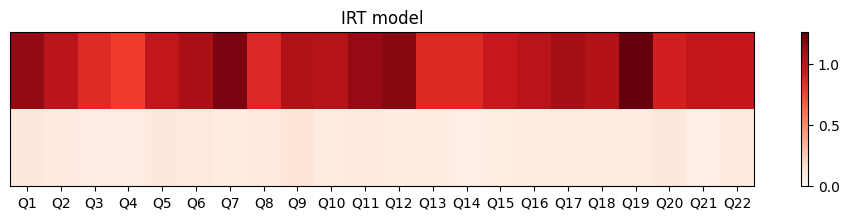

In [12]:
_ = plt.figure(figsize=(12, 2))
plt.pcolormesh(discrim_mean[0, ..., 0], vmin=0, cmap="Reds")
_ = plt.colorbar()
_ = plt.title("IRT model")
_ = plt.yticks([])
_ = plt.xticks(
    np.arange(grm.num_items) + 0.5, labels=[f"Q{j+1}" for j in range(grm.num_items)]
)

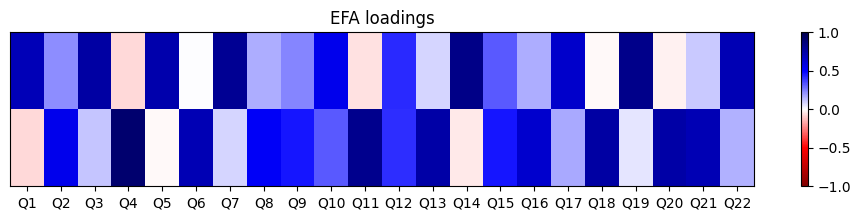

In [13]:
_ = plt.figure(figsize=(12, 2))

plt.pcolormesh(loadings.T, cmap="seismic_r", vmin=-1, vmax=1)
plt.colorbar()
_ = plt.yticks([])
_ = plt.xticks(
    np.arange(grm.num_items) + 0.5, labels=[f"Q{j+1}" for j in range(grm.num_items)]
)
_ = plt.title("EFA loadings")

In [14]:
scale_indices = [np.where(discrim_mean[0, ..., 0][0, :] > .5)[0].tolist()]
scale_indices += [[i for i in range(22) if i not in scale_indices[0]]]


In [15]:
difficulties = tf.cumsum(
    tf.concat(
        [params['difficulties0'], params['ddifficulties']], axis=-1
    ), axis=-1
)

In [16]:
difficulties_mean = tf.reduce_mean(difficulties, axis=[0, 1])
difficulties_mean = tf.transpose(difficulties_mean, (1, 0, 2))
difficulties_mean.shape


TensorShape([22, 2, 8])

# Build fully factorized model

In [17]:
fgrm = FactorizedGRModel(
    data=tfdata,
    item_keys=item_names,
    num_people=num_people,
    dim=dim,
    eta_scale=1e-4,
    kappa_scale=1e-4,
    weight_exponent=1,
    response_cardinality=9,
    scale_indices=scale_indices,
    discrimination_guess=tf.cast(np.abs(loadings).T, tf.float64)[tf.newaxis, :, :, tf.newaxis]
)

# MCMC

In [27]:
all_data = next(iter(tfdata.batch(11901)))
key_vals = list(grm.sample().keys())


In [28]:
def log_p(*params):
    lp = grm.unormalized_log_prob(data=all_data, **dict(zip(key_vals, params)))
    return lp


log_p(*list(grm.sample(1).values()))

<tf.Tensor: shape=(1,), dtype=float64, numpy=array([-1.92621985e+09])>

In [29]:

num_results = int(1e3)
# Burn-in steps.
num_burnin_steps = int(1e4)
# Hamiltonian Monte Carlo transition kernel. 
# In TFP a TransitionKernel returns a new state given some old state.
hcm_kernel  = tfp.mcmc.HamiltonianMonteCarlo(
  target_log_prob_fn=log_p,
  step_size=1.0e-1,
  num_leapfrog_steps=5
  
)
# This adapts the inner kernel's step_size.
adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
  inner_kernel = hcm_kernel,
  num_adaptation_steps=int(num_burnin_steps * 0.8)
)

@tf.function
def run_chain():
  # Run the chain (with burn-in). 
  # Implements MCMC via repeated TransitionKernel steps.
  samples, is_accepted = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      kernel=adaptive_hmc,
      trace_fn=lambda _, pkr: pkr.inner_results.is_accepted,
      current_state=list(grm.sample(1).values())
    )
  return samples

In [30]:
num_chains = 3
# Run sampling. 
chains = [run_chain() for i in range(num_chains)]
mcmc_samples = [dict(zip(key_vals, x)) for x in chains]

In [31]:
mcmc_samples_ = mcmc_samples[0]
for mcmc_samples__ in mcmc_samples[1:]:
    for k, v in mcmc_samples__.items():
        mcmc_samples_[k] = tf.concat([mcmc_samples_[k], v], axis=0)

mcmc_samples = {k: v[:, 0, ...] for k, v in mcmc_samples_.items()}

In [32]:
discrim_mcmc = mcmc_samples['discriminations']
discrim_mcmc_mean = tf.reduce_mean(discrim_mcmc, axis=0)

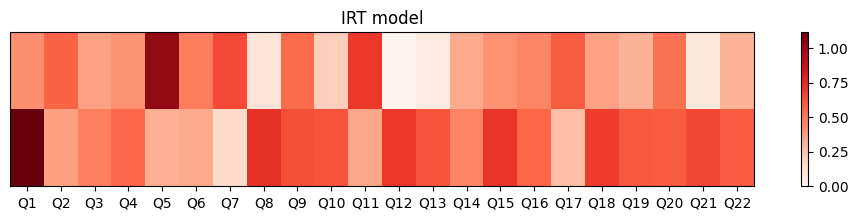

In [33]:
_ = plt.figure(figsize=(12, 2))
plt.pcolormesh(discrim_mcmc_mean[0, ..., 0], vmin=0, cmap="Reds")
_ = plt.colorbar()
_ = plt.title("IRT model")
_ = plt.yticks([])
_ = plt.xticks(
    np.arange(grm.num_items) + 0.5, labels=[f"Q{j+1}" for j in range(grm.num_items)]
)

# Fit by projecting the original model

In [34]:
fgrm.fit_projection(grm, data_factory_factory(shuffle=True, repeat=True), num_steps=500)

Running optimization for 500 steps of 1 accumulated batches, checking every 1 steps
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/31100635-bcb2-4a93-b5a6-172f6d7d3642/31100635-bcb2-4a93-b5a6-172f6d7d3642-1


  0%|          | 0/500 [00:00<?, ?it/s]

Step 1: average-batch loss:0.22681560965887473 rel loss: inf
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/31100635-bcb2-4a93-b5a6-172f6d7d3642/31100635-bcb2-4a93-b5a6-172f6d7d3642-2


/Users/changjc/workspace/autoencirt/../bayesianquilts/bayesianquilts/util.py:233: RuntimeWarning: overflow encountered in scalar divide
  rel = np.abs(deviation / loss)
  0%|          | 1/500 [00:01<15:39,  1.88s/it]

Step 2: average-batch loss:0.06714640408160037 rel loss: 2.3779263798435832
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/31100635-bcb2-4a93-b5a6-172f6d7d3642/31100635-bcb2-4a93-b5a6-172f6d7d3642-3


  0%|          | 2/500 [00:02<07:26,  1.12it/s]

Step 3: average-batch loss:0.1607418925122841 rel loss: 0.5822719078881757
New learning rate: 0.95


  1%|          | 3/500 [00:02<04:34,  1.81it/s]

Step 4: average-batch loss:0.18131681830752847 rel loss: 0.6296736027668737
New learning rate: 0.9025


  1%|          | 4/500 [00:02<03:19,  2.49it/s]

Step 5: average-batch loss:0.15915292197857397 rel loss: 0.5781013427410401
New learning rate: 0.8573749999999999


  1%|          | 5/500 [00:02<02:32,  3.25it/s]

Step 6: average-batch loss:0.12378682441118068 rel loss: 0.45756420846081924
New learning rate: 0.8145062499999999


  1%|          | 6/500 [00:02<02:05,  3.94it/s]

Step 7: average-batch loss:0.08867150249636538 rel loss: 0.24275102833232487
New learning rate: 0.7737809374999998
We are in a loss plateau
Restoring from a checkpoint


  1%|▏         | 7/500 [00:02<01:48,  4.56it/s]

Step 8: average-batch loss:0.05852789965520658 rel loss: 0.1472546337245352
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/31100635-bcb2-4a93-b5a6-172f6d7d3642/31100635-bcb2-4a93-b5a6-172f6d7d3642-4


  2%|▏         | 8/500 [00:03<01:38,  4.97it/s]

Step 9: average-batch loss:0.04193242938277066 rel loss: 0.39576696405896095
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/31100635-bcb2-4a93-b5a6-172f6d7d3642/31100635-bcb2-4a93-b5a6-172f6d7d3642-5


  2%|▏         | 9/500 [00:03<01:33,  5.25it/s]

Step 10: average-batch loss:0.03940239102391835 rel loss: 0.06421027488703694
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/31100635-bcb2-4a93-b5a6-172f6d7d3642/31100635-bcb2-4a93-b5a6-172f6d7d3642-6


  2%|▏         | 10/500 [00:03<01:39,  4.94it/s]

Step 11: average-batch loss:0.04479083432747355 rel loss: 0.12030236508119851
New learning rate: 0.7350918906249998


  2%|▏         | 11/500 [00:03<01:31,  5.37it/s]

Step 12: average-batch loss:0.046268493611613594 rel loss: 0.14839693389049138
New learning rate: 0.6983372960937497


  2%|▏         | 12/500 [00:03<01:24,  5.78it/s]

Step 13: average-batch loss:0.038687910809247016 rel loss: 0.018467790059642115
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/31100635-bcb2-4a93-b5a6-172f6d7d3642/31100635-bcb2-4a93-b5a6-172f6d7d3642-7


  3%|▎         | 13/500 [00:03<01:25,  5.70it/s]

Step 14: average-batch loss:0.02669820302083182 rel loss: 0.44908295060382836
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/31100635-bcb2-4a93-b5a6-172f6d7d3642/31100635-bcb2-4a93-b5a6-172f6d7d3642-8


  3%|▎         | 14/500 [00:04<01:23,  5.83it/s]

Step 15: average-batch loss:0.018700516147829922 rel loss: 0.4276719856168236
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/31100635-bcb2-4a93-b5a6-172f6d7d3642/31100635-bcb2-4a93-b5a6-172f6d7d3642-9


  3%|▎         | 15/500 [00:04<01:22,  5.91it/s]

Step 16: average-batch loss:0.017219746476736058 rel loss: 0.08599253613253771
Saved a checkpoint: /var/folders/6s/m6kbjxb16sl9cg9rg6mj5czrv6ht9f/T/tfcheckpoints/31100635-bcb2-4a93-b5a6-172f6d7d3642/31100635-bcb2-4a93-b5a6-172f6d7d3642-10


  3%|▎         | 16/500 [00:04<01:22,  5.88it/s]

Step 17: average-batch loss:0.01937505163014134 rel loss: 0.11124125987113866
New learning rate: 0.6634204312890623


  3%|▎         | 17/500 [00:04<01:23,  5.80it/s]

Step 18: average-batch loss:0.021515534714608042 rel loss: 0.1996598408941863


  4%|▎         | 18/500 [00:04<01:20,  5.98it/s]

Terminating because the loss converged


  4%|▎         | 18/500 [00:04<02:09,  3.74it/s]


<tf.Tensor: shape=(18,), dtype=float64, numpy=
array([0.22681561, 0.0671464 , 0.16074189, 0.18131682, 0.15915292,
       0.12378682, 0.0886715 , 0.0585279 , 0.04193243, 0.03940239,
       0.04479083, 0.04626849, 0.03868791, 0.0266982 , 0.01870052,
       0.01721975, 0.01937505, 0.02151553])>

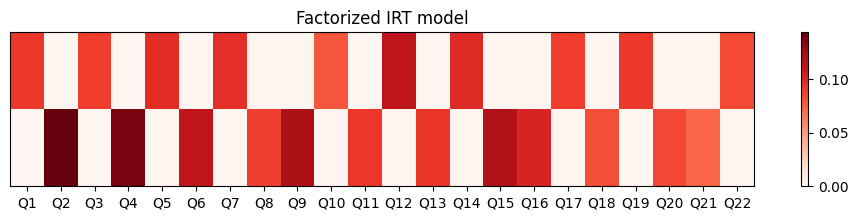

In [35]:
_ = plt.figure(figsize=(12, 2))

fparams = fgrm.sample(256)
fdiscrim = fparams['discriminations']
fdiscrim_mean = np.mean(fdiscrim, axis=0)
plt.pcolormesh(fdiscrim_mean[0, ..., 0], vmin=0, cmap='Reds')
_ = plt.colorbar()
_ = plt.title("Factorized IRT model")
_ = plt.yticks([])
_ = plt.xticks(
    np.arange(grm.num_items) + 0.5, labels=[f"Q{j+1}" for j in range(grm.num_items)]
)

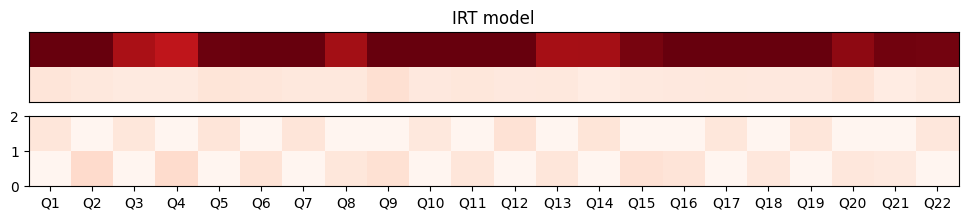

In [36]:
fig, ax = plt.subplots(2, 1, figsize=(12, 2))
ax[0].pcolormesh(discrim_mean[0, ..., 0], vmin=0, vmax=1, cmap="Reds")
ax[1].pcolormesh(fdiscrim_mean[0, ..., 0], vmin=0, vmax=1, cmap='Reds')


_ = ax[0].set_title("IRT model")
_ = ax[0].set_yticks([])
_ = ax[0].set_xticks([])
_ = ax[1].set_xticks(
    np.arange(grm.num_items) + 0.5, labels=[f"Q{j+1}" for j in range(grm.num_items)]
)

In [ ]:

fdifficulties = tf.cumsum(
    tf.concat(
        [fparams['difficulties0'], fparams['ddifficulties']], axis=-1
    ), axis=-1
)

fdifficulties_mean = tf.reduce_mean(fdifficulties, axis=[0, 1])
fdifficulties_mean = tf.transpose(fdifficulties_mean, (1, 0, 2))
fdifficulties_mean.shape


TensorShape([22, 2, 8])

In [ ]:
item_text

['The established authorities generally turn out to be right about things, while the radicals and protestors are usually just "loud mouths" showing off their ignorance.',
 'Women should have to promise to obey their husbands when they get married.',
 'Our country desperately needs a mighty leader who will do what has to be done to destroy the radical new ways and sinfulness that are ruining us.',
 'Gays and lesbians are just as healthy and moral as anybody else.',
 "It is always better to trust the judgement of the proper authorities in government and religion than to listen to the noisy rabble-rousers in our society who are trying to create doubt in people's minds.",
 'Atheists and others who have rebelled against the established religions are no doubt every bit as good and virtuous as those who attend church regularly.',
 'The only way our country can get through the crisis ahead is to get back to our traditional values, put some tough leaders in power, and silence the troublemakers 

In [24]:
{name: text for j, (name, text) in enumerate(zip(item_names, item_text))}

{'Q1': 'The established authorities generally turn out to be right about things, while the radicals and protestors are usually just "loud mouths" showing off their ignorance.',
 'Q2': 'Women should have to promise to obey their husbands when they get married.',
 'Q3': 'Our country desperately needs a mighty leader who will do what has to be done to destroy the radical new ways and sinfulness that are ruining us.',
 'Q4': 'Gays and lesbians are just as healthy and moral as anybody else.',
 'Q5': "It is always better to trust the judgement of the proper authorities in government and religion than to listen to the noisy rabble-rousers in our society who are trying to create doubt in people's minds.",
 'Q6': 'Atheists and others who have rebelled against the established religions are no doubt every bit as good and virtuous as those who attend church regularly.',
 'Q7': 'The only way our country can get through the crisis ahead is to get back to our traditional values, put some tough leader

# create JSON

In [25]:
discrim_mean[0, ..., 0].T.tolist()[0]
scale_names = ['A', 'B']

In [ ]:
responses = [
    "very strongly disagree",
    "strongly disagree",
    "moderately disagree",
    "slightly disagree",
    "feel neutral",
    "slightly agree",
    "moderately agree",
    "strongly agree",
    "very strongly agree",
]

mixed_model = [
    {
        "item": name,
        "question": text,
        "responses": {
            **{str(k + 1): {"text": r, "value": k + 1 if j not in to_reverse else 9-k} for k, r in enumerate(responses)},
            "0": {'text': 'skip', 'value': 0}
        },
        "scales": {
            scale_names[k]: {"discrimination": lam, 'difficulties': dif} for k, (lam, dif) in enumerate(zip(dis, diff))
        },
    }
    for j, (name, text, dis, diff) in enumerate(
        zip(item_names, item_text, discrim_mean[0, ..., 0].T.tolist(), difficulties_mean.numpy().tolist())
    )
]

mixed_model[0]

{'item': 'Q1',
 'question': 'The established authorities generally turn out to be right about things, while the radicals and protestors are usually just "loud mouths" showing off their ignorance.',
 'responses': {'1': {'text': 'very strongly disagree', 'value': 1},
  '2': {'text': 'strongly disagree', 'value': 2},
  '3': {'text': 'moderately disagree', 'value': 3},
  '4': {'text': 'slightly disagree', 'value': 4},
  '5': {'text': 'feel neutral', 'value': 5},
  '6': {'text': 'slightly agree', 'value': 6},
  '7': {'text': 'moderately agree', 'value': 7},
  '8': {'text': 'strongly agree', 'value': 8},
  '9': {'text': 'very strongly agree', 'value': 9},
  '0': {'text': 'skip', 'value': 0}},
 'scales': {'A': {'discrimination': 0.3984886371341793,
   'difficulties': [-0.7248988564909062,
    1.0120588728583917,
    2.4669530484798923,
    3.5928662869672534,
    5.022269118864349,
    6.268621503321225,
    7.772509163682496,
    9.090770362781658]},
  'B': {'discrimination': 1.9254756245962

In [ ]:
!pwd

/Users/changjc/workspace/autoencirt


In [28]:
factorized_model = [
    {
        "item": name,
        "question": text,
        "responses": {
            **{str(k + 1): {"text": r, "value": k + 1 if j not in to_reverse else 9-k} for k, r in enumerate(responses)},
            "0": {'text': 'skip', 'value': 0}
        },
        "scales": {
            scale_names[k]: {"discrimination": lam, 'difficulties': dif} for k, (lam, dif) in enumerate(zip(dis, diff)) if lam > 0
        },
    }
    for j, (name, text, dis, diff) in enumerate(
        zip(item_names, item_text, fdiscrim_mean[0, ..., 0].T.tolist(), fdifficulties_mean.numpy().tolist())
    )
]
factorized_model[0]

{'item': 'Q1',
 'question': 'The established authorities generally turn out to be right about things, while the radicals and protestors are usually just "loud mouths" showing off their ignorance.',
 'responses': {'1': {'text': 'very strongly disagree', 'value': 1},
  '2': {'text': 'strongly disagree', 'value': 2},
  '3': {'text': 'moderately disagree', 'value': 3},
  '4': {'text': 'slightly disagree', 'value': 4},
  '5': {'text': 'feel neutral', 'value': 5},
  '6': {'text': 'slightly agree', 'value': 6},
  '7': {'text': 'moderately agree', 'value': 7},
  '8': {'text': 'strongly agree', 'value': 8},
  '9': {'text': 'very strongly agree', 'value': 9},
  '0': {'text': 'skip', 'value': 0}},
 'scales': {'B': {'discrimination': 0.2834101614339964,
   'difficulties': [-3.995819851650581,
    -0.7456062819817335,
    1.4597727329709103,
    2.5008166827516503,
    4.037838633257399,
    5.762449710031884,
    8.43384467077668,
    11.881555865570473]}}}

In [29]:
for x in factorized_model:
    with open(f"RWAS/factorized/{x['item']}.json", 'w') as f:
        json.dump(x, f, indent=2)

In [30]:
for x in mixed_model:
    with open(f"RWAS/autoencoded/{x['item']}.json", 'w') as f:
        json.dump(x, f, indent=2)

In [31]:
import xarray as xr

In [32]:
xparams = xr.DataArray({k: x.numpy() for k, x in params.items()})